In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

tf_keras = tf.contrib.keras

In [2]:
model_params = {
    "num_classes": 10, # number of classes
    "input_shape": (32, 32, 3), # input image size
    "conv_kernel": (3,3), # convolutional feature map size
    "pool_kernel": (2,2), # pooling window size
    "batch_size": 32 # number of samples per batch
}
hyper_params = {
    "l2_regularization": 0.0005,
    "dropout": 0.5, # ratio of neurons to drop during trainin
    "learning_rate": 0.0001 # learning rate
}

In [3]:
# convolutional layer
def conv2d(filters):
    return tf_keras.layers.Conv2D(filters, model_params["conv_kernel"],
                                 padding='same',
                                 activation=tf.nn.relu,
                                 kernel_regularizer=
                                  tf.contrib.layers.l2_regularizer(hyper_params["l2_regularization"]))

# Block: conv - BN - conv - maxpool - dropout
def convBlockFunction(filters, inputs):
    net = conv2d(filters)(inputs)
    net = tf_keras.layers.BatchNormalization()(net)
    net = conv2d(filters)(net)
    net = tf_keras.layers.MaxPool2D(model_params["pool_kernel"])(net)
    return tf_keras.layers.Dropout(0.25)(net)

# curried conv block
def convBlock(filters):
    def convBlockCurried(inputs):
        return convBlockFunction(filters,inputs)
    return convBlockCurried

In [4]:
# dense block
def denseBlockFunction(units, inputs):
    net = tf_keras.layers.Dense(units)(inputs)
    return tf_keras.layers.Dropout(hyper_params["dropout"])(net)

# curried dense block
def denseBlock(units):
    def denseBlockCurried(inputs):
        return denseBlockFunction(units, inputs)
    return denseBlockCurried

In [5]:
def VGG():

    # TensorFlow default graph
    tf.reset_default_graph()

    # input image tensor
    inputs = tf_keras.layers.Input(shape=model_params["input_shape"])

    # convolutional blocks
    # Block: conv - BN - conv - maxpool - dropout
    net = convBlock(64)(inputs)
    net = convBlock(128)(net)
    net = convBlock(256)(net)

    net = tf_keras.layers.Flatten()(net)

    # fully connected blocks
    net = denseBlock(1024)(net)
    net = denseBlock(512)(net)

    # final layer
    outputs = tf_keras.layers.Dense(model_params["num_classes"],
                                    activation = tf.nn.softmax)(net)
    
    # model
    model = tf_keras.models.Model(inputs=inputs, outputs=outputs)
    
    return model

In [6]:
def compile_model(model):
    
    # loss
    loss = tf_keras.losses.categorical_crossentropy

    # Adam optimizer
    optimizer = tf_keras.optimizers.Adam(lr=hyper_params["learning_rate"])
    
    # metrics
    metrics = [tf_keras.metrics.categorical_accuracy,
               tf_keras.metrics.top_k_categorical_accuracy]
    

    # compile the model with loss, optimizer and evaluation metrics
    model.compile(loss = loss,
                  optimizer = optimizer,
                  metrics = metrics)

    print(model.summary())
    
    return model

In [7]:
vgg = VGG()
vgg = compile_model(vgg)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 64)        1792      
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 64)        256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 128)       73856     
__________

In [8]:
# load Cifar dataset
(x_train, y_train), (x_test, y_test) = tf_keras.datasets.cifar10.load_data()

# Turn target values into one-hot encoded vectors
y_train = tf_keras.utils.to_categorical(y_train, model_params["num_classes"])
y_test = tf_keras.utils.to_categorical(y_test, model_params["num_classes"])

In [9]:
# data generator augmentation configuration for training
train_datagen = tf_keras.preprocessing.image.ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

# data generator augmentation configuration for testing
# only rescaling
test_datagen = tf_keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255)

In [10]:
# Training generator
train_generator = train_datagen.flow(x=x_train, y=y_train,
                                     batch_size=model_params["batch_size"])

# Testing generator
validation_generator = test_datagen.flow(x=x_test, y=y_test,
                                         batch_size=model_params["batch_size"])

In [11]:
# fits the model on batches with real-time data augmentation
history = vgg.fit_generator(train_generator,
                            steps_per_epoch=300,#x_train.shape[0]//batch_size
                            epochs=10,
                            validation_data=validation_generator,
                            validation_steps=100)

Epoch 1/10
300/300 [==============================] - 1427s 5s/step - loss: 5.6581 - categorical_accuracy: 0.2083 - top_k_categorical_accuracy: 0.6857 - val_loss: 3.8231 - val_categorical_accuracy: 0.1325 - val_top_k_categorical_accuracy: 0.5494
Epoch 2/10
300/300 [==============================] - 1430s 5s/step - loss: 3.5282 - categorical_accuracy: 0.2602 - top_k_categorical_accuracy: 0.7755 - val_loss: 2.0266 - val_categorical_accuracy: 0.3494 - val_top_k_categorical_accuracy: 0.8619
Epoch 3/10
300/300 [==============================] - 1425s 5s/step - loss: 2.6352 - categorical_accuracy: 0.2959 - top_k_categorical_accuracy: 0.8170 - val_loss: 1.7399 - val_categorical_accuracy: 0.4300 - val_top_k_categorical_accuracy: 0.8981
Epoch 4/10
300/300 [==============================] - 1369s 5s/step - loss: 2.2617 - categorical_accuracy: 0.3278 - top_k_categorical_accuracy: 0.8441 - val_loss: 1.6983 - val_categorical_accuracy: 0.4459 - val_top_k_categorical_accuracy: 0.9159
Epoch 5/10
300/3

In [13]:
# evaluate the model on batches with real-time data augmentation
loss, acc, top_k_acc= vgg.evaluate_generator(validation_generator,
                                             steps = 200)
print("loss: {}".format(loss))
print("accuracy: {}".format(acc))
print("top 5 accuracy: {}".format(top_k_acc))

loss: 1.64502052248
accuracy: 0.4871875
top 5 accuracy: 0.92796875


In [14]:
# make predictions on batches with real-time data augmentation
predictions = vgg.predict_generator(validation_generator, steps = 100)

In [15]:
def plot_accuracy_and_loss(history):
    plt.figure(1, figsize= (15, 10))
    
    # plot train and test accuracy
    plt.subplot(221)
    plt.plot(history.history['categorical_accuracy'])
    plt.plot(history.history['val_categorical_accuracy'])
    plt.title('vgg accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')

    # plot train and test loss
    plt.subplot(222)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('vgg loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    
    plt.show()

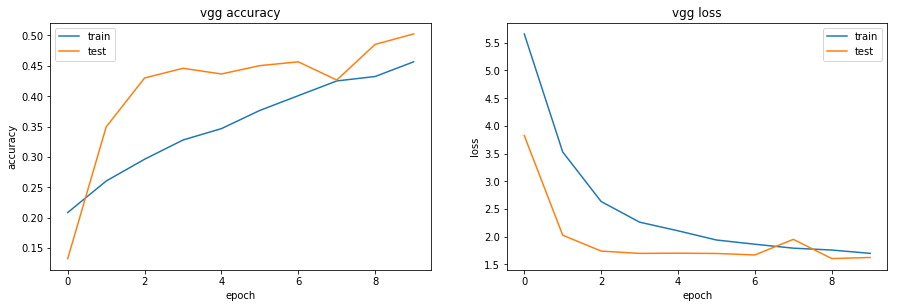

In [16]:
plot_accuracy_and_loss(history)

In [ ]:
#save model
vgg_json = vgg.to_json()
open('cifar10_vgg.json', 'w').write(vgg_json)
vgg.save_weights('image_classifier_cifar10.h5', overwrite=True)